# Implementing a Probabilistic Numerical Method

In this guide we will explain how to implement a probabilistic numerical method in ProbNum. As a simple example problem we consider optimization of a possibly noisy quadratic objective $f : \mathbb{R} \rightarrow \mathbb{R}$. We assume we only have access to function evaluations
$$
y = f(x) = \frac{1}{2}ax^2 + bx + c
$$

where in the stochastic case the parameters are corrupted by an additive noise term.

This particular problem was used to showcase *what* a PN method *is* in the [tutorial on PN methods](../tutorials/pn_methods.ipynb). Now we will turn to *how* to implement such a method in ProbNum. This tutorial is split into two parts. The first outlines the interface, the function most users will call. The second explains the class which actually implements the algorithm.

Note, this development tutorial focusses on explaining the design and structure of the implementation of a probabilistic numerical method, not necessarily on efficiency for the solution of this particular problem.

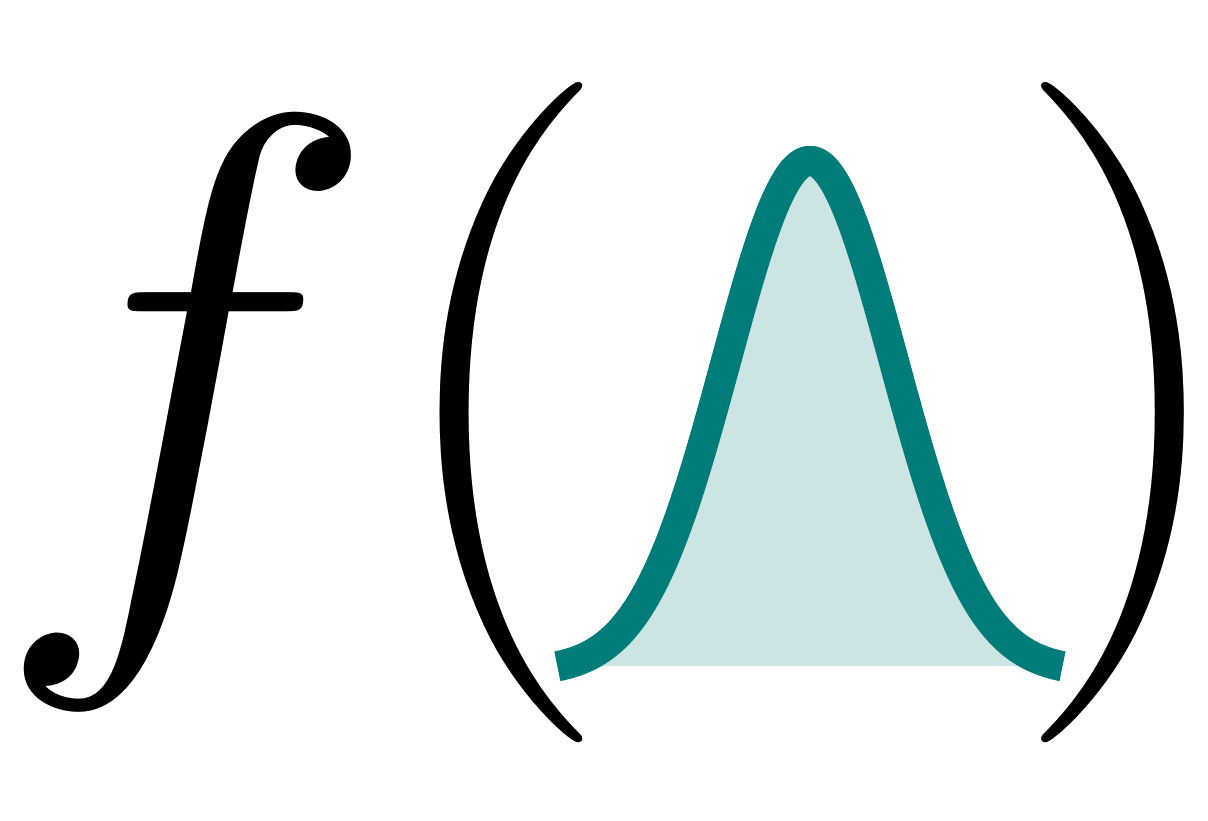

In [1]:
from IPython.display import Image

# Thumbnail in tutorial gallery
display(Image(filename="../img/pn_logo.png", width=250, embed=True)) 

## Interface

Each probabilistic numerical method in ProbNum has an interface defined via a function, e.g. [probnum.diffeq.probsolve_ivp](../automod/probnum.diffeq.probsolve_ivp.rst#probnum.diffeq.probsolve_ivp). This is the primary way the average user of ProbNum interacts with the library. Such an interface will typically allow different variants of the same probabilistic numerical method to be called depending on the problem or a user-supplied argument. Similar designs can be found in other libraries (see e.g. [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)).

### Signature

If your method has a classic analogue in NumPy or SciPy, make sure the method signatures match as closely as possible. This enables PN methods to be used as drop-in replacements for classic numerical routines, e.g.

```python
# Solve using NumPy
x = np.linalg.solve(A, b)

# Solve using ProbNum
x_rv, _, _, info = pn.linalg.problinsolve(A, b)
```

In the case where a classic numerical method exists, the naming scheme typically adheres to the convention `bayes<classic_method>()` or `prob<classic_method>()`. In our example we want our function to be callable as

```python
x, _, _, info = pn.optim.probsolve_qp(lambda x: 2 * x ** 2 - 5)
```

### Method `probsolve_qp`

We will now take a closer look at the interface of our 1D noisy quadratic optimization method. At a basic level `probsolve_qp` takes a function of the type `Callable[[FloatArgType], FloatArgType]`. This hints that the optimization objective is a 1D function. Our prior knowledge about the parameters $(a,b,c)$ is encoded in the random variable `fun_params0`. However, we want to also give a user the option to not specify any prior knowledge or just a guess about the parameter values, hence this argument is optional or can be an `np.ndarray`. 

The interface also has an `assume_fun` argument, which allows specification of the variant of the probabilistic numerical method to use based on the assumptions about the problem. For convenience, this can be inferred from the problem itself. The actual implementation of the PN method variant which is initialized in a modular fashion is separate from the interface and will be explained later. Finally, the actual optimization routine is called and the result is returned.

In [ ]:
# %load -s probsolve_qp quadopt_example/_quadratic_programming
def probsolve_qp(
    fun: Callable[[FloatArgType], FloatArgType],
    fun_params0: Optional[Union[np.ndarray, pn.RandomVariable]] = None,
    assume_fun: Optional[str] = None,
    tol: FloatArgType = 10 ** -5,
    maxiter: IntArgType = 10 ** 4,
    noise_cov: Optional[Union[np.ndarray, linops.LinearOperator]] = None,
    callback: Optional[
        Callable[[FloatArgType, FloatArgType, pn.RandomVariable], None]
    ] = None,
    random_state: RandomStateArgType = None,
) -> Tuple[float, pn.RandomVariable, pn.RandomVariable, Dict]:
    """
    Probabilistic 1D Quadratic Optimization.

    PN method solving unconstrained one-dimensional (noisy) quadratic
    optimization problems only needing access to function evaluations.

    Parameters
    ----------
    fun :
        Quadratic objective function to optimize.
    fun_params0 :
        *(shape=(3, ) or (3, 1))* -- Prior on the parameters of the
        objective function or initial guess for the parameters.
    assume_fun :
        Type of probabilistic numerical method to use. The available
        options are

        =====================  =============
         automatic selection   ``None``
         exact observations    ``"exact"``
         noisy observations    ``"noise"``
        =====================  =============

        If ``None`` the type of method is inferred from the problem
        ``fun`` and prior ``fun_params0``.
    tol :
        Convergence tolerance.
    maxiter :
        Maximum number of iterations.
    noise_cov :
        *(shape=(3, 3))* -- Covariance of the additive noise on the parameters
        of the noisy objective function.
    callback :
        Callback function returning intermediate quantities of the
        optimization loop. Note that depending on the function
        supplied, this can slow down the solver considerably.
    random_state :
        Random state of the solver. If None (or ``np.random``), the global
        ``np.random`` state is used. If integer, it is used to seed the local
        :class:`~numpy.random.RandomState` instance.

    Returns
    -------
    x_opt :
        Estimated minimum of the objective function.
    fun_opt :
        Belief over the optimal value of the objective function.
    fun_params :
        Belief over the parameters of the objective function.
    info :
        Additional information about the optimization, e.g. convergence.

    Examples
    --------
    >>> f = lambda x: 2.0 * x ** 2 - 0.75 * x + 0.2
    >>> x_opt, fun_opt, fun_params_opt, info = probsolve_qp(f)
    >>> print(info["iter"])
    3
    """

    # Choose a variant of the PN method
    if assume_fun is None:
        # Infer PN variant to use based on the problem
        if noise_cov is not None or fun(1.0) != fun(1.0):
            assume_fun = "noise"
        else:
            assume_fun = "exact"

    # Select appropriate prior based on the problem
    fun_params0 = _choose_prior(fun_params0=fun_params0)

    # Create a local instance of the random number generator if none is provided
    random_state = _utils.as_random_state(random_state)

    if assume_fun == "exact":
        # Exact 1D quadratic optimization
        probquadopt = ProbabilisticQuadraticOptimizer(
            fun_params_prior=fun_params0,
            policy=partial(stochastic_policy, random_state=random_state),
            observation_operator=function_evaluation,
            belief_update=partial(gaussian_belief_update, noise_cov=np.zeros(3)),
            stopping_criteria=[
                partial(parameter_uncertainty, abstol=tol, reltol=tol),
                partial(maximum_iterations, maxiter=maxiter),
            ],
        )
    elif assume_fun == "noise":
        # Noisy 1D quadratic optimization
        probquadopt = ProbabilisticQuadraticOptimizer(
            fun_params_prior=fun_params0,
            policy=partial(explore_exploit_policy, random_state=random_state),
            observation_operator=function_evaluation,
            belief_update=partial(gaussian_belief_update, noise_cov=noise_cov),
            stopping_criteria=[
                partial(parameter_uncertainty, abstol=tol, reltol=tol),
                partial(maximum_iterations, maxiter=maxiter),
            ],
        )
    else:
        raise ValueError(f'Unknown assumption on function evaluations: "{assume_fun}".')

    # Run optimization iteration
    x_opt0, fun_opt0, fun_params0, info = probquadopt.optimize(
        fun=fun, callback=callback
    )

    # Return output with information (e.g. on convergence)
    info["assume_fun"] = assume_fun
    return x_opt0, fun_opt0, fun_params0, info


We can now call `probsolve_qp` to solve a simple deterministic quadratic optimization problem. We only specify the problem and let the interface determine the problem type, prior information and appropriate variant of the solver. As expected, we converge in three iterations.

In [6]:
import probnum
from quadopt_example import probsolve_qp

# Objective function
fun = lambda x: 2.0 * x ** 2 - 0.8 * x + 0.2

# Probabilistic 1D quadratic optimization
x_opt, fun_opt, fun_params, info = probsolve_qp(fun)

print(info)
print(fun_params.mean)
print(x_opt)

{'iter': 3, 'conv_crit': 'uncertainty_abstol', 'assume_fun': 'exact'}
[ 4.  -0.8  0.2]
0.19999999999999915


Now let's consider a noise-corrupted problem. We will provide a guess for the parameters of the quadratic. The interface automatically detects that it is faced with a noisy problem and an appropriate prior aligned with the provided point estimate for the parameters `fun_params0` is specified.

In [7]:
import probnum.random_variables as rvs

# Stochastic quadratic objective
np.random.seed(42)
noise_cov = 0.00005 * np.eye(3)


def fun_hat(x):
    a, b, c = rvs.Normal(np.array([4.0, -0.8, 0.2]), noise_cov).sample()
    return 0.5 * a * x ** 2 + b * x + c


x_opt, fun_opt, fun_params, info = probsolve_qp(
    fun_hat, fun_params0=np.array([1.0, -1.0, 0.0]), noise_cov=noise_cov
)

print(info)
print(fun_params.mean)
print(x_opt)

{'iter': 2627, 'conv_crit': 'uncertainty_reltol', 'assume_fun': 'noise'}
[ 4.0073941  -0.80027018  0.19997452]
0.1996983972892166


Before you add your own new interface, look through the codebase whether an interface for your PN method exists. You can then simply write an implementation (see below) and call it from the interface function.



## Implementation

There are often different variations of a given (probabilistic) numerical routine depending on the arguments supplied. In ProbNum these are implemented in a compositional manner. This allows more advanced users to create custom variants and more easily allows additions and changes to the interface. Implementing the solver in a compositional manner means that its components, i.e. policy, observation process, belief update and stopping criteria can be easily "swapped out" with minor changes to the code. Typically, [compositionality is preferred over inheritance](https://en.wikipedia.org/wiki/Composition_over_inheritance) since it avoids having to create combinatorially many new classes when adding a new method variant.

The components of the `ProbabilisticQuadraticOptimizer` are implemented as functions in separate modules. The different variants of the same component all share the same initial arguments and may have additional ones adjusting their behaviour.

### Class `ProbabilisticQuadraticOptimizer`

We will start by getting an overview of the actual class implementing the 1D probabilistic quadratic optimizer. Based on the compositional pattern it pulls together all the components and calls them with their respective arguments in the right order. 

The optimization iteration `.optimize` steps through a generator given by `.optim_iterator` one action and observation at a time until any of the stopping criteria are fulfilled. The generator gives control to an advanced user over the output of each iteration and allows more granular testing.

In [ ]:
# %load -s ProbabilisticQuadraticOptimizer quadopt_example/_quadratic_programming
class ProbabilisticQuadraticOptimizer:
    """
    Probabilistic Quadratic Optimization in 1D

    PN method solving unconstrained one-dimensional (noisy) quadratic
    optimization problems only needing access to function evaluations.

    Parameters
    ----------
    fun_params_prior :
        Prior belief over the parameters of the latent quadratic function.
    policy :
        Callable returning a new action to probe the problem.
    observation_operator :
        Callable implementing the observation process of the problem.
    belief_update :
        Belief update function updating the belief over the parameters of the quadratic given
        an action and observation of the problem.
    stopping_criteria :
        Stopping criteria to determine when to stop the optimization.

    See Also
    --------
    probsolve_qp : Solve 1D (noisy) quadratic optimization problems.

    Examples
    --------
    >>> from functools import partial
    >>> import numpy as np
    >>> import probnum.random_variables as rvs
    >>> from quadopt_example.policies import stochastic_policy
    >>> from quadopt_example.observation_operators import function_evaluation
    >>> from quadopt_example.belief_updates import gaussian_belief_update
    >>> from quadopt_example.stopping_criteria import maximum_iterations
    >>>
    >>> np.random.seed(42)
    >>>
    >>> # Custom stopping criterion based on residual
    >>> def residual(
    >>>     fun,
    >>>     fun_params0,
    >>>     current_iter,
    >>>     abstol=10 ** -6,
    >>>     reltol=10 ** -6,
    >>> ):
    >>>     a, b, c = fun_params0.mean
    >>>     resid = np.abs(fun(1.0) - (0.5 * a + b + c))
    >>>     if resid < abstol:
    >>>         return True, "residual_abstol"
    >>>     elif resid < np.abs(fun(1.0)) * reltol:
    >>>         return True, "residual_reltol"
    >>>     else:
    >>>         return False, None
    >>>
    >>> # Compose custom PN method
    >>> quadopt = ProbabilisticQuadraticOptimizer(
    >>>     fun_params_prior=rvs.Normal(np.zeros(3), np.eye(3)),
    >>>     policy=stochastic_policy,
    >>>     observation_operator=function_evaluation,
    >>>     belief_update=partial(gaussian_belief_update, noise_cov=np.zeros(3)),
    >>>     stopping_criteria=[residual, partial(maximum_iterations, maxiter=10)],
    >>> )
    >>> # Objective function
    >>> f = lambda x: 2.0 * x ** 2 - 0.75 * x + 0.2
    >>>
    >>> quadopt.optimize(f)
    (0.2000000000000014,
     <() Normal with dtype=float64>,
     <(3,) Normal with dtype=float64>,
     {'iter': 3, 'conv_crit': 'residual_abstol'})
    """

    def __init__(
        self,
        fun_params_prior: pn.RandomVariable,
        policy: QuadOptPolicyType,
        observation_operator: QuadOptObservationOperatorType,
        belief_update: QuadOptBeliefUpdateType,
        stopping_criteria: Union[
            QuadOptStoppingCriterionType, Iterable[QuadOptStoppingCriterionType]
        ],
    ):
        # Optimizer components
        self.fun_params = fun_params_prior
        self.policy = policy
        self.observation_operator = observation_operator
        self.belief_update = belief_update

        if not isinstance(stopping_criteria, collections.abc.Iterable):
            self.stopping_criteria = [stopping_criteria]
        else:
            self.stopping_criteria = stopping_criteria

    def has_converged(
        self, fun: Callable[[FloatArgType], FloatArgType], iteration: IntArgType
    ) -> Tuple[bool, Union[str, None]]:
        """
        Check whether the optimizer has converged.

        Parameters
        ----------
        fun :
            Quadratic objective function to optimize.
        iteration :
            Number of iterations of the solver performed up to this point.
        """
        for stopping_criterion in self.stopping_criteria:
            _has_converged, convergence_criterion = stopping_criterion(
                fun, self.fun_params, iteration
            )
            if _has_converged:
                return True, convergence_criterion
        return False, None

    def optim_iterator(
        self,
        fun: Callable[[FloatArgType], FloatArgType],
    ) -> Tuple[float, float, pn.RandomVariable]:
        """
        Generator implementing the optimization iteration.

        This function allows stepping through the optimization
        process one step at a time.

        Parameters
        ----------
        fun :
            Quadratic objective function to optimize.

        Returns
        -------
        action :
            Action to probe the problem.
        observation :
            Observation of the problem for the given ``action``.
        fun_params :
            Belief over the parameters of the objective function.
        """
        while True:
            # Compute action via policy
            action = self.policy(fun, self.fun_params)

            # Make an observation
            observation = self.observation_operator(fun, action)

            # Belief update
            self.fun_params = self.belief_update(self.fun_params, action, observation)

            yield action, observation, self.fun_params

    def optimize(
        self,
        fun: Callable[[FloatArgType], FloatArgType],
        callback: Optional[Callable[[float, float, pn.RandomVariable], None]] = None,
    ) -> Tuple[float, pn.RandomVariable, pn.RandomVariable, Dict]:
        """
        Optimize the quadratic objective function.

        Parameters
        ----------
        fun :
            Quadratic objective function to optimize.
        callback :
            Callback function returning intermediate quantities of the
            optimization loop. Note that depending on the function
            supplied, this can slow down the solver considerably.

        Returns
        -------
        x_opt :
            Estimated minimum of ``fun``.
        fun_opt :
            Belief over the optimal value of the objective function.
        fun_params :
            Belief over the parameters of the objective function.
        info :
            Additional information about the optimization, e.g. convergence.
        """
        # Setup
        _has_converged = False
        iteration = 0
        optimization_iterator = self.optim_iterator(fun=fun)

        # Evaluate stopping criteria
        _has_converged, conv_crit = self.has_converged(fun=fun, iteration=iteration)

        while not _has_converged:

            # Perform one iteration of the optimizer
            action, observation, _ = next(optimization_iterator)

            # Callback function
            if callback is not None:
                callback(action, observation, self.fun_params)

            iteration += 1

            # Evaluate stopping criteria
            _has_converged, conv_crit = self.has_converged(fun=fun, iteration=iteration)

        # Belief over optimal function value and optimum
        x_opt, fun_opt = self.belief_optimum()

        # Information (e.g. on convergence)
        info = {"iter": iteration, "conv_crit": conv_crit}

        return x_opt, fun_opt, self.fun_params, info

    def belief_optimum(self) -> Tuple[float, pn.RandomVariable]:
        """
        Compute the belief over the optimum and optimal function value.

        Returns
        -------
        x_opt :
            Estimated minimum of ``fun``.
        fun_opt :
            Belief over the optimal value of the objective function.
        """
        x_opt = -self.fun_params.mean[1] / self.fun_params.mean[0]
        fun_opt = np.array([0.5 * x_opt ** 2, x_opt, 1]).T @ self.fun_params
        return x_opt, fun_opt


### Interlude: Type Hints

In order to decrease the number of bugs and increase maintainability these implementations must have [type
hints](https://docs.python.org/3/library/typing.html). Type hints are as their name suggests a way to indicate the type of an object. Python is a dynamically typed language, meaning variable types are inferred at runtime not at compile time. Type hints allow static type checking instead, i.e. one can use automated tools to check whether function arguments of the wrong type are supplied without actually running the code.

Additionally to the types provided by the `typing` module, ProbNum defines two kinds of custom types. These are defined to simplify and reuse commonly used types across modules.

**API Types** are aliases which define custom types used throughout the library. Objects of
this type may be supplied as arguments or returned by a method. For example if we pass a shape to a function, then we would use a `ShapeType`, defined as

```python
ShapeType = Tuple[int, ...]
```
where the ellipsis (`...`) denotes arbitrary length of the tuple of `int`s.

**Argument Types** are aliases which define commonly used method arguments. These should
only ever be used in the signature of a method and then be converted internally, e.g.
in a class instantiation or an interface. They enable the user to conveniently
specify a variety of object types for the same argument, while ensuring a unified
internal representation of those same objects. Canonical examples are different kinds of integer or float types, which might be passed by a user. These are all unified internally.

```python
IntArgType = Union[int, numbers.Integral, np.integer]
FloatArgType = Union[float, numbers.Real, np.floating]

ShapeArgType = Union[IntArgType, Iterable[IntArgType]]
"""Type of a public API argument for supplying a shape. Values of this type should
always be converted into :class:`ShapeType` using the function
:func:`probnum.utils.as_shape` before further internal processing."""
```

As a small example we write a function which takes a shape and extends that shape with an integer. The type hinted implementation of this function would look like this.

In [2]:
from probnum.type import ShapeType, IntArgType, ShapeArgType
from probnum.utils import as_shape


def extend_shape(shape: ShapeArgType, extension: IntArgType) -> ShapeType:
    return as_shape(shape) + as_shape(extension)

If we now pass a shape which has a different type than `ShapeType`, we still get a `ShapeType` object back.

In [3]:
import numpy as np

m = np.int32(2)
n = 4
l = np.int16(1)
print(f"Type of m: {type(m)}, n: {type(n)} and l: {type(l)}.")

Type of m: <class 'numpy.int32'>, n: <class 'int'> and l: <class 'numpy.int16'>.


In [4]:
newshape = extend_shape([m, n], extension=l)
print(f"Type of newshape: {type(newshape)}({type(newshape[0])}, {type(newshape[1])}, {type(newshape[2])}).")

Type of newshape: <class 'tuple'>(<class 'int'>, <class 'int'>, <class 'int'>).


### Policy, Action and Observation

We now take a closer look at the components making up our PN method. Consider the exploration vs. exploitation policy explained in the [original tutorial](../tutorials/pn_methods.ipynb#Policy). Any policy is called with the objective function and the current belief over the parameters.

In [ ]:
# %load -s explore_exploit_policy quadopt_example/policies
def explore_exploit_policy(
    fun: Callable[[FloatArgType], FloatArgType],
    fun_params0: pn.RandomVariable,
    random_state: RandomStateArgType = None,
) -> float:
    """
    Policy exploring around the estimate of the minimum based on the certainty about the
    parameters.

    Parameters
    ----------
    fun :
        One-dimensional objective function.
    fun_params0 :
        Belief over the parameters of the quadratic objective.
    random_state :
        Random state of the policy. If None (or np.random), the global np.random state
        is used. If integer, it is used to seed the local
        :class:`~numpy.random.RandomState` instance.
    """
    a0, b0, c0 = fun_params0
    return (
        -b0.mean / a0.mean
        + rvs.Normal(0, np.trace(fun_params0.cov), random_state=random_state).sample()
    )


In this case since the policy is stochastic it has a `random_state` argument. The random number generator has to be set prior to initialization of `ProbabilisticQuadraticOptimizer`, since every policy is expected to have `QuadOptPolicyType`.

```python
QuadOptPolicyType = Callable[
    [
        Callable[[FloatArgType], FloatArgType],
        pn.RandomVariable
    ],
    FloatArgType,
]
```
The observation process for this problem is very simple. It just evaluates the objective function. 
```python
QuadOptObservationOperatorType = Callable[
    [Callable[[FloatArgType], FloatArgType], FloatArgType], FloatArgType
]
```
One can imagine a different probabilistic optimization method which evaluates the gradient as well. In this case the different observation processes would all get the function, its gradient and an evaluation point / action as arguments.

In [ ]:
# %load -s function_evaluation quadopt_example/observation_operators
def function_evaluation(
    fun: Callable[[FloatArgType], FloatArgType], action: FloatArgType
) -> np.float_:
    """
    Observe a (noisy) function evaluation of the quadratic objective.

    Parameters
    ----------
    fun :
        Quadratic objective function to optimize.
    action :
        Input to the objective function.
    """
    observation = fun(action)
    try:
        return _utils.as_numpy_scalar(observation, dtype=np.floating)
    except TypeError as exc:
        raise TypeError(
            "The given argument `p` can not be cast to a `np.floating` object."
        ) from exc


### Belief Update

The belief update follows the same design pattern as the policy and observation process. Any belief update is passed the current belief over the parameters, an action and an observation.
```python
QuadOptBeliefUpdateType = Callable[
    [
        pn.RandomVariable,
        FloatArgType,
        FloatArgType,
    ],
    pn.RandomVariable,
]
```
In this simple example we assume the noise covariance to be known and it is therefore not part of the call to the belief update but a separate argument.

In [ ]:
# %load -s gaussian_belief_update quadopt_example/belief_updates
def gaussian_belief_update(
    fun_params0: pn.RandomVariable,
    action: FloatArgType,
    observation: FloatArgType,
    noise_cov: Union[np.ndarray, linops.LinearOperator],
) -> pn.RandomVariable:
    """
    Update the belief over the parameters with an observation.

    Parameters
    ----------
    fun_params0 :
        Belief over the parameters of the quadratic objective.
    action :
        Action of the probabilistic quadratic optimizer.
    observation :
        Observation of the problem corresponding to the given `action`.
    noise_cov :
        *shape=(3, 3)* -- Covariance of the noise on the parameters of the quadratic
        objective given by the assumed observation model.
    """
    # Feature vector
    x = np.asarray(action).reshape(1, -1)
    Phi = np.vstack((0.5 * x ** 2, x, np.ones_like(x)))

    # Mean and covariance
    mu = fun_params0.mean
    Sigma = fun_params0.cov

    # Gram matrix
    gram = Phi.T @ (Sigma + noise_cov) @ Phi

    # Posterior Mean
    m = mu + Sigma @ Phi @ np.linalg.solve(gram, observation - Phi.T @ mu)

    # Posterior Covariance
    S = Sigma - Sigma @ Phi @ np.linalg.solve(gram, Phi.T @ Sigma)

    return rvs.Normal(mean=m, cov=S)


### Stopping Criteria

The stopping criteria are also implemented as simple methods, which return a `bool` determining convergence and a string giving the name of the criterion.
```python
QuadOptStoppingCriterionType = Callable[
    [Callable[[FloatArgType], FloatArgType], pn.RandomVariable, IntArgType],
    Tuple[bool, Union[str, None]],
]
```
As an example consider the parameter uncertainty based stopping criterion.

In [ ]:
# %load -s parameter_uncertainty quadopt_example/stopping_criteria
def parameter_uncertainty(
    fun: Callable[[FloatArgType], FloatArgType],
    fun_params0: pn.RandomVariable,
    current_iter: IntArgType,
    abstol: FloatArgType,
    reltol: FloatArgType,
) -> Tuple[bool, Union[str, None]]:
    """
    Termination based on numerical uncertainty about the parameters.

    Parameters
    ----------
    fun :
        One-dimensional objective function.
    fun_params0 :
        Belief over the parameters of the quadratic objective.
    current_iter :
        Current iteration of the PN method.
    abstol :
        Absolute convergence tolerance.
    reltol :
        Relative convergence tolerance.
    """
    # Uncertainty over parameters given by the trace of the covariance.
    trace_cov = np.trace(fun_params0.cov)
    if trace_cov < abstol:
        return True, "uncertainty_abstol"
    elif trace_cov < np.linalg.norm(fun_params0.mean, ord=2) ** 2 * reltol:
        return True, "uncertainty_reltol"
    else:
        return False, None


As we will see, one can pass multiple stopping criteria to the solver, which will all be checked in turn.

### Composing a Custom `ProbabilisticQuadraticOptimizer`

Finally, we will demonstrate how to use the compositional pattern we implemented to create a custom `ProbabilisticQuadraticOptimizer`. In this fashion one can easily extend the interface `probsolve_qp` with new variants as a developer or flexibly adjust the internal parts of the optimizer.

In [13]:
from functools import partial
import numpy as np
import probnum.random_variables as rvs
from quadopt_example import ProbabilisticQuadraticOptimizer
from quadopt_example.policies import stochastic_policy
from quadopt_example.observation_operators import function_evaluation
from quadopt_example.belief_updates import gaussian_belief_update
from quadopt_example.stopping_criteria import maximum_iterations

# Custom stopping criterion based on residual
def residual(
    fun,
    fun_params0,
    current_iter,
    abstol=10 ** -5,
    reltol=10 ** -5,
):
    """
    Termination based on the residual.
    """
    a, b, c = fun_params0.mean
    resid = np.abs(fun(1.0) - (0.5 * a + b + c))
    if resid < abstol:
        return True, "residual_abstol"
    elif resid < np.abs(fun(1.0)) * reltol:
        return True, "residual_reltol"
    else:
        return False, None


# Compose custom PN method
quadopt = ProbabilisticQuadraticOptimizer(
    fun_params_prior=rvs.Normal(np.zeros(3), np.eye(3)),
    policy=stochastic_policy,
    observation_operator=function_evaluation,
    belief_update=partial(gaussian_belief_update, noise_cov=np.zeros(3)),
    stopping_criteria=[residual, partial(maximum_iterations, maxiter=10)],
)

In [14]:
np.random.seed(42)

# Step through solver iteration
i = 0
for action, observation, fun_params in quadopt.optim_iterator(fun=fun):

    print(f"Action: {action}\nObservation: {observation}\nParameter estimate:{fun_params.mean}\n")
    _has_converged, conv_crit = quadopt.has_converged(fun=fun, iteration=i)

    if _has_converged:
        print(f"Algorithm converged with stopping criterion `{conv_crit}`.")
        break

    i += 1

Action: 0.4967141530112327
Observation: 0.2960785771943464
Parameter estimate:[0.02894345 0.11653965 0.23462115]

Action: -0.13826430117118466
Observation: 0.34884547489365986
Parameter estimate:[-0.00320257 -0.08252632  0.33746564]

Action: 0.6476885381006925
Observation: 0.5208500542934704
Parameter estimate:[ 4.  -0.8  0.2]

Algorithm converged with stopping criterion `residual_abstol`.


We can see that our new stopping criterion is hit after three iterations on an exact problem.

## Tests and Examples

While or even before you add a new PN method, write tests for its functionality. Writing tests before the 
code forces you to think about what your numerical method should do independent of its implementation. Some help for writing tests for PN methods can be found in the ["Writing Tests" developer guide](../development/unit_testing.ipynb).

Once you are done, consider writing an [example notebook](../development/creating_an_example_notebook.ipynb)
explaining how to use your new method and its benefits. This will encourage others to try it and gives you a chance to show off your hard work.

Congratulations you just implemented your first probabilistic numerical method in ProbNum!